## SECHILIENNE - Essai 3 - Data 1994 - 2005 ONLY WITH DISPLACEMENT

In [1]:
# Manipulation des données
# ============================================================================
import numpy as np
import pandas as pd

# Plots
# ============================================================================
import matplotlib.pyplot as plt

# Modeling and forecasting
# ============================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Warning configuration
# ============================================================================
import warnings

In [2]:
# Data importation
# ============================================================================
data = pd.read_excel('Data_Sechilienne_Test2.xlsx')

# Data preparation
# ============================================================================
data['Date'] = pd.to_datetime(data['Date'], format = '%Y/%m/%d')
data = data.set_index('Date')
data = data.asfreq('D')
data = data.sort_index()

data = data.rename(columns = {'Speed_mm/d_A13_(EM)': 'Deplacement'})
data = data.rename(columns = {'Rainfall_mm' : 'Pluie'})

data.head()

,Année,Mois,Jour,Deplacement,Pluie,Snowmelt_mm,Rainfall+Snowmelt_mm
Date,,,,,,,
1994-01-01,1994,1,1,1.94,2.2,1.2,3.4
1994-01-02,1994,1,2,1.55,0.0,0.0,0.0
1994-01-03,1994,1,3,1.37,0.0,0.0,0.0
1994-01-04,1994,1,4,1.36,0.0,0.0,0.0
1994-01-05,1994,1,5,1.37,0.0,0.0,0.0


In [3]:
# Verification du nombre de valeurs manquantes
# ============================================================================
print(f'Nombre de lignes avec des valeurs manquantes : {data.isnull().any(axis=1).mean()}')

Nombre de lignes avec des valeurs manquantes : 0.0


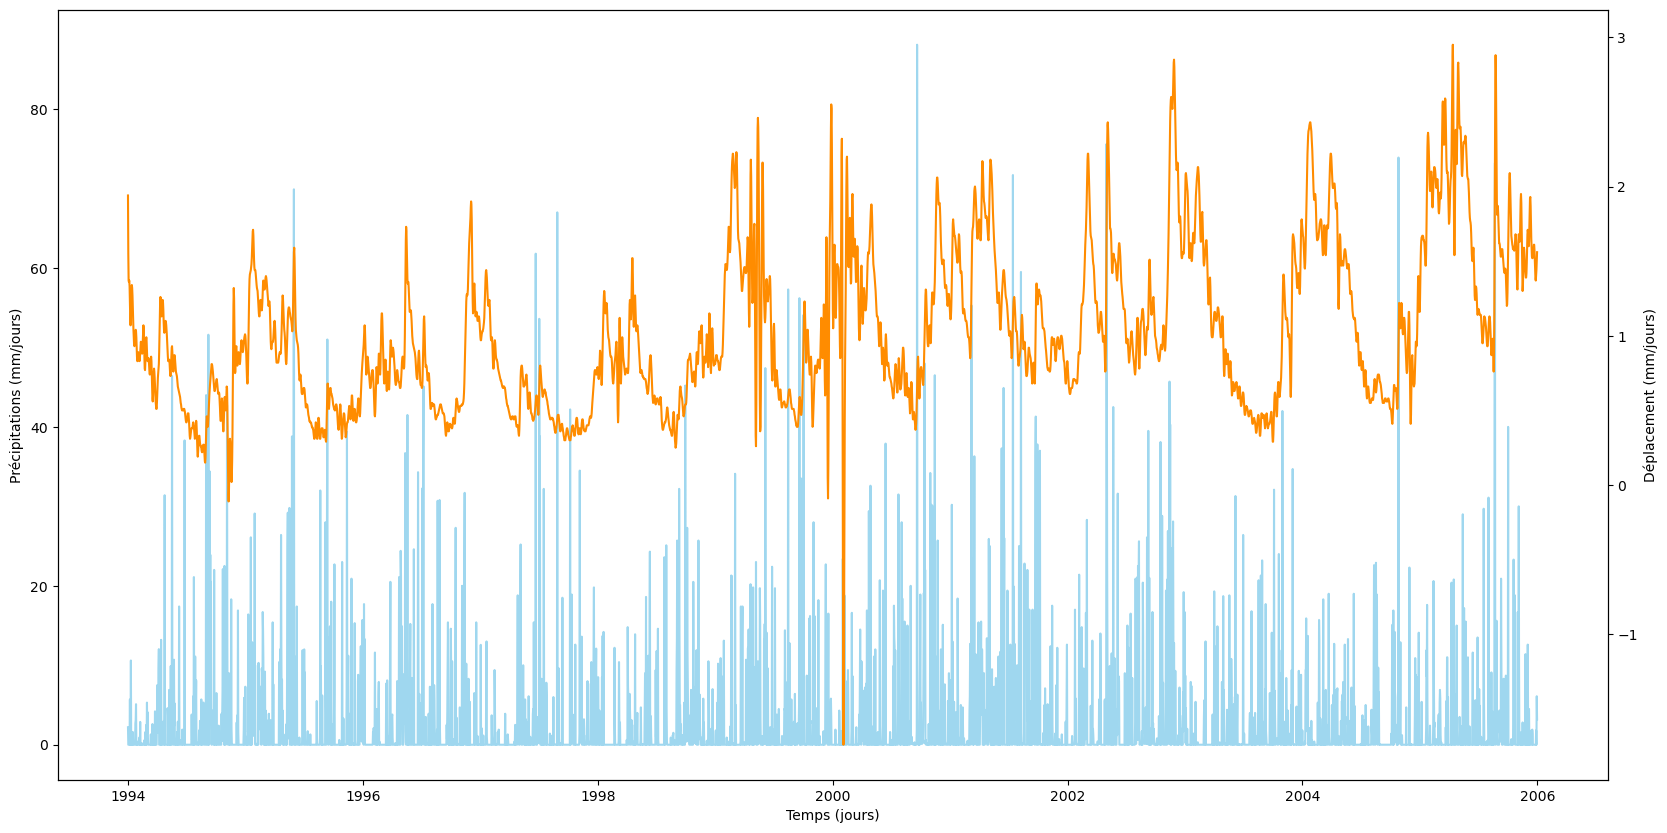

In [4]:
# Plot des séries d'origine
# ============================================================================
fig, ax1 = plt.subplots(figsize = (20,10))

ax1.plot(data['Pluie'], label = 'Précipitation', color = 'skyblue', alpha = 0.8)
ax1.set_xlabel('Temps (jours)')
ax1.set_ylabel('Précipitations (mm/jours)')

ax2 = ax1.twinx()

ax2.plot(data['Deplacement'], label = 'Déplacement', color = 'darkorange')
ax2.set_xlabel('Temps (jours)')
ax2.set_ylabel('Déplacement (mm/jours)')

plt.show()

In [5]:
# Split des données en Train-Test set
# ============================================================================
steps = 1095
data_train = data[:-steps]
data_test = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()} (n={len(data_train)})")
print(f"Test dates : {data_test.index.min()} --- {data_test.index.max()} (n={len(data_test)})")

Train dates : 1994-01-01 00:00:00 --- 2003-01-01 00:00:00 (n=3288)
Test dates : 2003-01-02 00:00:00 --- 2005-12-31 00:00:00 (n=1095)


In [6]:
# Création et entrainement du forecasteur
# ============================================================================
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(123), lags = 8)

forecaster.fit(y=data_train['Deplacement'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(n_estimators=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1994-01-01 00:00:00'), Timestamp('2003-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 123, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-01-05 12:44:16 
Last fit date: 2023-01-05 12:44:17 
Skforecast version: 0.6.0 
Python version: 3.9.13 

In [7]:
# Predictions
# ============================================================================
predictions = forecaster.predict(steps=steps)

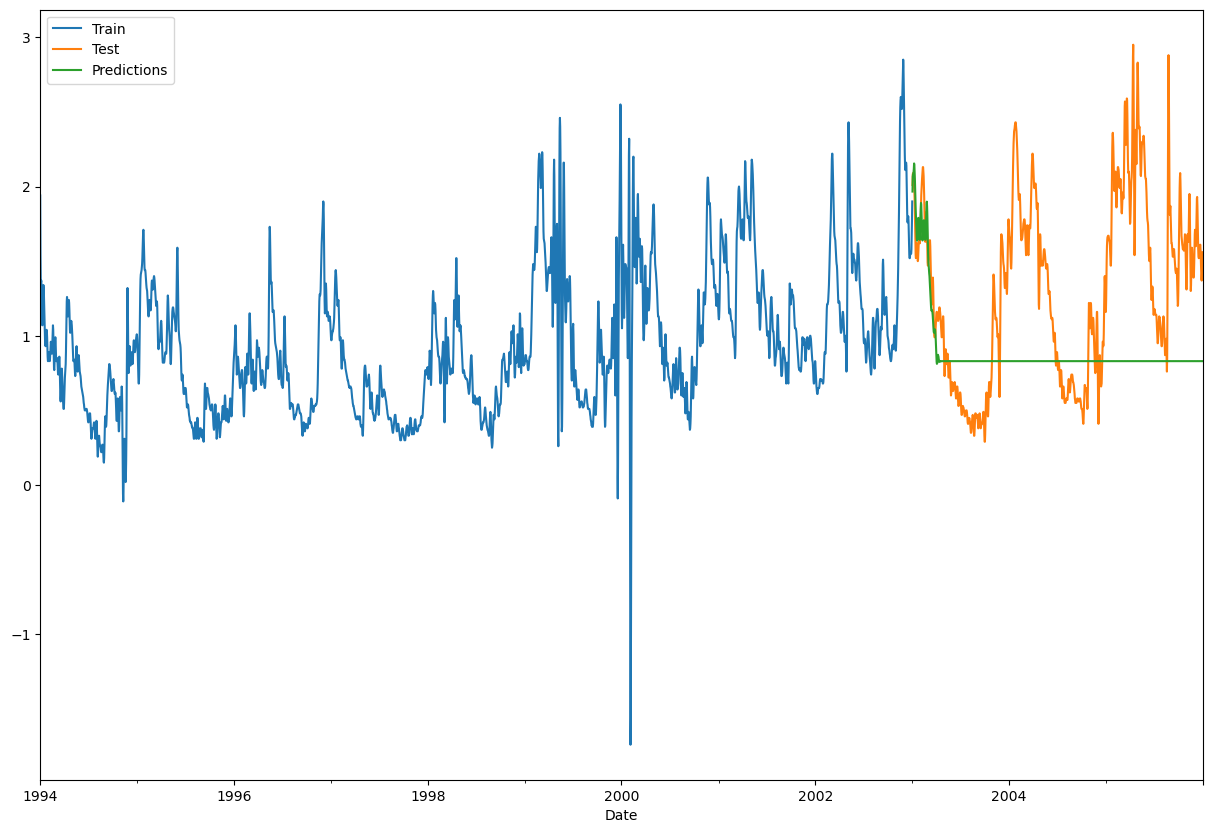

In [8]:
# Plot
# ============================================================================
fig, ax = plt.subplots(figsize = (15,10))
data_train['Deplacement'].plot(ax=ax, label = 'Train')
data_test['Deplacement'].plot(ax=ax, label = 'Test')
predictions.plot(ax=ax, label = 'Predictions')

ax.legend()

In [ ]:
# Test error
# ============================================================================
error_mse = mean_squared_error(y_true = data_test['Deplacement'], y_pred = predictions)

print(f"Test error (mse) : {error_mse}")

In [9]:
# Hyperparameter Grid Search
# ============================================================================
steps = 1095
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123), lags = 12)

lags_grid = [5, 12, 10]

param_grid = {'n_estimators' : [50, 100, 500],
             'max_depth' : [3, 5, 10]}

results_grid = grid_search_forecaster(
                                forecaster = forecaster,
                                y = data_train['Deplacement'],
                                param_grid = param_grid,
                                lags_grid = lags_grid,
                                steps = steps,
                                refit = True,
                                metric = 'mean_squared_error',
                                initial_train_size = int(len(data_train)*0.5),
                                return_best = True,
                                verbose = False
                            )

Number of models compared: 27.


loop lags_grid: 100%|██████████████████████████████████████| 3/3 [07:46<00:00, 155.43s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 3, 'n_estimators': 50}
  Backtesting metric: 0.395455460884846



In [10]:
# Grid Search result
# ============================================================================
results_grid.head()

,lags,params,mean_squared_error,max_depth,n_estimators
18,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 50}",0.395455,3,50
1,"[1, 2, 3, 4, 5]","{'max_depth': 3, 'n_estimators': 100}",0.396637,3,100
0,"[1, 2, 3, 4, 5]","{'max_depth': 3, 'n_estimators': 50}",0.397358,3,50
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.397469,3,500
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.398219,3,100


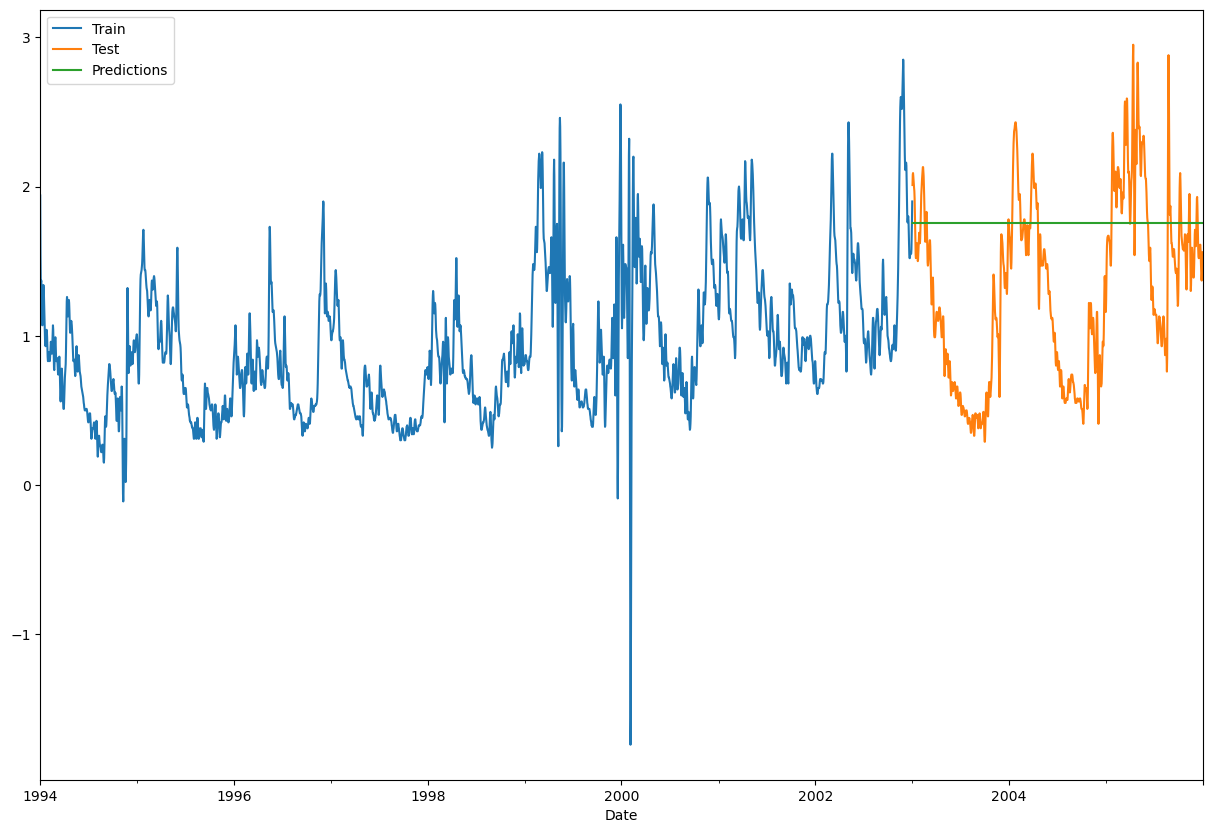

In [12]:
# Predictions
# ============================================================================
predictions = forecaster.predict(steps = steps)

# Plot
# ============================================================================
fig, ax = plt.subplots(figsize = (15,10))
data_train['Deplacement'].plot(ax=ax, label = 'Train')
data_test['Deplacement'].plot(ax=ax, label = 'Test')
predictions.plot(ax=ax, label = 'Predictions')

ax.legend()